In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('co2.txt')
df.head()

,year,month,decimal,average,trend
0,1980,1,1980.042,338.55,337.93
1,1980,2,1980.125,339.27,338.22
2,1980,3,1980.208,339.60,338.25
3,1980,4,1980.292,340.00,338.37
4,1980,5,1980.375,340.43,338.90


In [3]:
ts = df.decimal.values
f_ts = df.average.values

X = np.vstack((ts, np.ones_like(ts))).T
Y = f_ts.reshape(-1, 1)

In [4]:
prior_mean = np.array([0., 360.]).reshape(-1, 1)
prior_cov = np.array([[10.**2, 0.], [0., 100.**2]])
prior_precision = np.linalg.inv(prior_cov)
sigma_sq = 1.

posterior_cov = np.linalg.inv(prior_precision + X.T@X/sigma_sq)
posterior_mean = posterior_cov @ (prior_precision@prior_mean + X.T@Y/sigma_sq)

print(f'posterior mean =\n{posterior_mean}\nposterior_cov =\n{posterior_cov}')

posterior mean =
[[ 1.81842808e+00]
 [-3.26615096e+03]]
posterior_cov =
[[ 1.37479698e-05 -2.75073908e-02]
 [-2.75073908e-02  5.50396935e+01]]


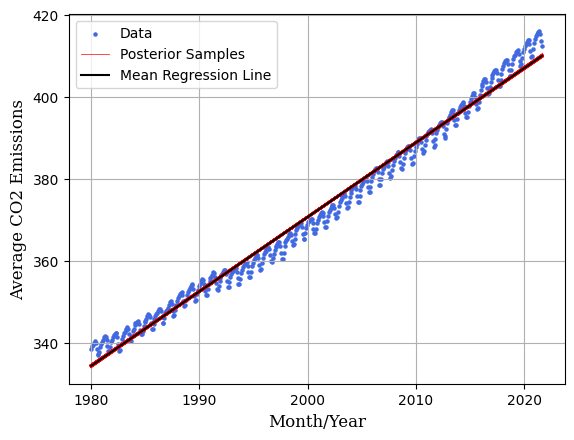

In [5]:
x_values = np.linspace(min(ts), max(ts), 2)

def calculate_regression_line(x, weights):
    return weights[0] * x + weights[1]

plt.scatter(ts, f_ts, color='royalblue', s=5, label='Data')

num_samples = 100
for i in range(num_samples):
    sampled_weights = np.random.multivariate_normal(posterior_mean.flatten(), posterior_cov)
    y_values = calculate_regression_line(x_values, sampled_weights)
    if i == 0:
        plt.plot(x_values, y_values, color='red', linewidth=0.5, label='Posterior Samples')
    else:
        plt.plot(x_values, y_values, color='red')

mean_y_values = calculate_regression_line(x_values, posterior_mean.flatten())
plt.plot(x_values, mean_y_values, color='black', linewidth=1.5, label='Mean Regression Line')

plt.xlabel('Month/Year', font='serif', size=12)
plt.ylabel('Average CO2 Emissions', font='serif', size=12)
plt.grid()
plt.legend()
plt.show()

In [6]:
delta = 1e-4
x = np.arange(posterior_mean[0][0]-delta, posterior_mean[0][0]+delta, delta/100)
y = np.arange(posterior_mean[1][0]-delta, posterior_mean[1][0]+delta, delta/100)

x, y = np.meshgrid(x, y)
grid = np.stack((x, y), axis=2)

In [7]:
var = multivariate_normal(mean=posterior_mean.flatten(), cov=posterior_cov, allow_singular=True)
F_grid = np.apply_along_axis(var.pdf, 2, grid)

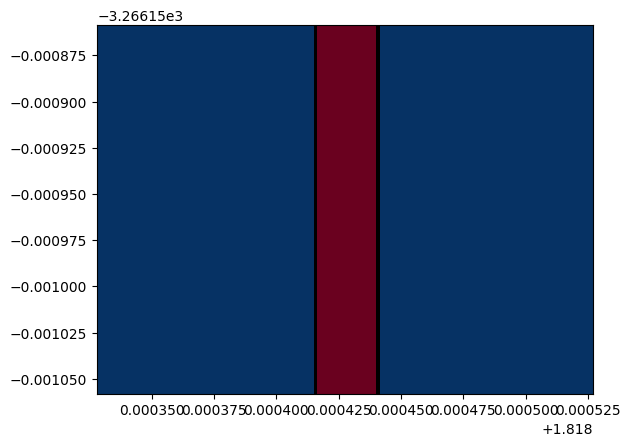

In [8]:
fig, ax = plt.subplots()
ax.contour(x, y, F_grid, levels=100, linewidths=0.5, colors='k')
cntr1 = ax.contourf(x, y, F_grid, levels=100, cmap="RdBu_r")
plt.show()

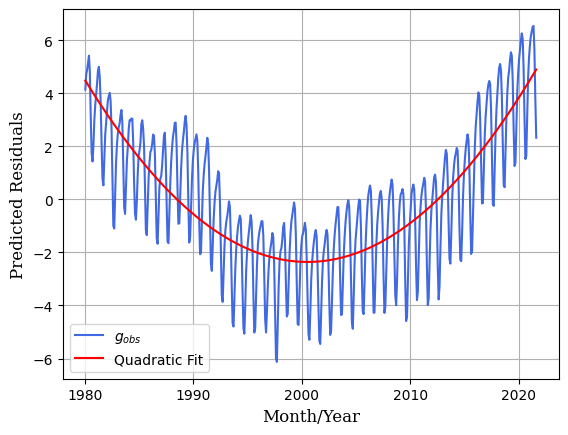

In [9]:
g_obs = f_ts - (X@posterior_mean).flatten()
X_quad = np.hstack((np.expand_dims(ts**2, 1), X))
mle = np.linalg.inv(X_quad.T@X_quad) @ X_quad.T @ g_obs

plt.plot(ts, g_obs, color='royalblue', label=r'$g_{obs}$')
plt.plot(ts, X_quad@mle, color='red', label='Quadratic Fit')

plt.xlabel('Month/Year', font='serif', size=12)
plt.ylabel('Predicted Residuals', font='serif', size=12)
plt.legend()
plt.grid()
plt.show()

In [10]:
def kernel_mat_from_kernel_fn(kernel_fn, x1, x2=None):

    if x2 is None:
        x2 = x1
    kernel_mat = np.zeros((x1.shape[0], x2.shape[0]))
    for i in range(x1.shape[0]):
        for j in range(x2.shape[0]):
            kernel_mat[i, j] = kernel_fn(x1[i], x2[j])

    return kernel_mat

def gp_sample(xs, kernel_fn):

    kernel_mat = kernel_mat_from_kernel_fn(kernel_fn, xs)
    sample = np.random.multivariate_normal(mean=np.zeros(xs.shape[0]), cov=kernel_mat, )

    return sample

In [11]:
def kernel_fn(theta_sq=0., sigma_sq=1., tau=1., phi_sq=0., eta_sq=1., zeta_sq=0.):

    return lambda s, t: theta_sq * (
        np.exp(-(2/sigma_sq) * np.sin(np.pi*(s-t)/tau)**2) +
        phi_sq * np.exp(-(s-t)**2 / (2*eta_sq))
    ) + (zeta_sq if s == t else 0)

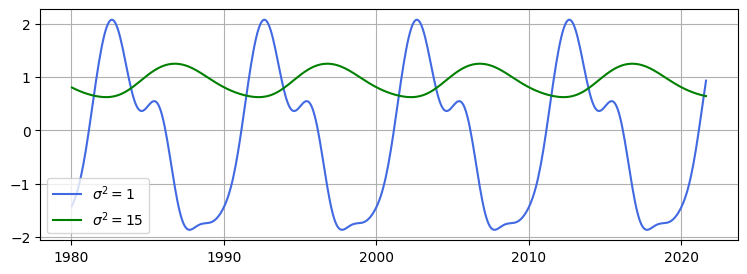

In [12]:
# sigma_sq controls the variation (smoothness) within cycles of the periodic functions
#   high sigma_sq increases covariance between points, leading to smoother cycles

plt.figure(figsize=(9, 3))
sample = gp_sample(ts, kernel_fn(theta_sq=1., sigma_sq=1., tau=10.))
plt.plot(ts, sample, color='royalblue', label=r'$\sigma^2 = 1$')
sample = gp_sample(ts, kernel_fn(theta_sq=1., sigma_sq=15., tau=10.))
plt.plot(ts, sample, color='green', label=r'$\sigma^2 = 15$')
plt.legend()
plt.grid()
plt.show()

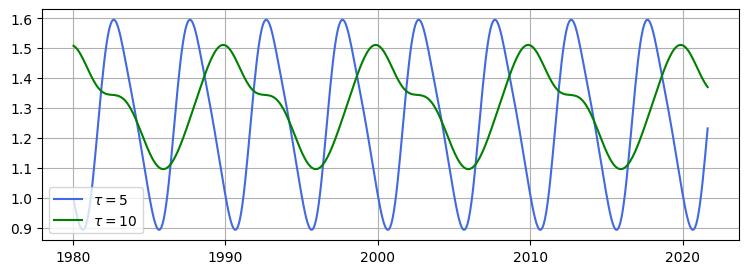

In [13]:
# tau controls the length of the cycles (period of the functions)

plt.figure(figsize=(9, 3))
sample = gp_sample(ts, kernel_fn(theta_sq=1., sigma_sq=10., tau=5.))
plt.plot(ts, sample, color='royalblue', label=r'$\tau = 5$')
sample = gp_sample(ts, kernel_fn(theta_sq=1., sigma_sq=10., tau=10.))
plt.plot(ts, sample, color='green', label=r'$\tau = 10$')
plt.legend()
plt.grid()
plt.show()

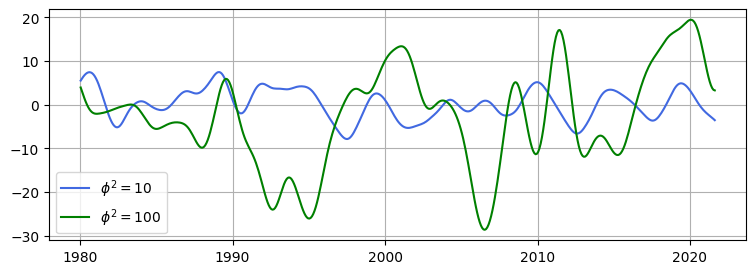

In [14]:
# phi_sq controls the amplitude of the underlying path

plt.figure(figsize=(9, 3))
sample = gp_sample(ts, kernel_fn(theta_sq=1., tau=5., phi_sq=10.))
plt.plot(ts, sample, color='royalblue', label=r'$\phi^2 = 10$')
sample = gp_sample(ts, kernel_fn(theta_sq=1., tau=5., phi_sq=100.))
plt.plot(ts, sample, color='green', label=r'$\phi^2 = 100$')
plt.legend()
plt.grid()
plt.show()

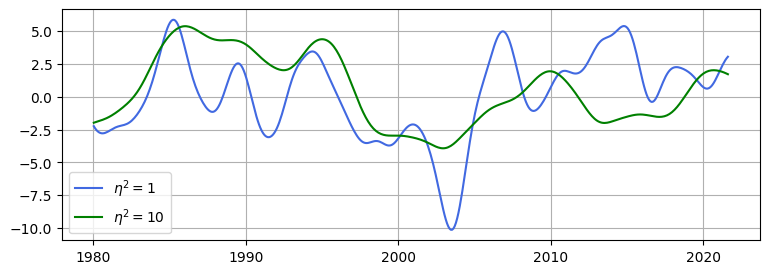

In [15]:
# eta_sq controls the smoothness of the underlying paths
#   higher eta_sq increases covariance between points, leading to smoother underlying paths

plt.figure(figsize=(9, 3))
sample = gp_sample(ts, kernel_fn(theta_sq=1., tau=10., phi_sq=10., eta_sq=1.))
plt.plot(ts, sample, color='royalblue', label=r'$\eta^2 = 1$')
sample = gp_sample(ts, kernel_fn(theta_sq=1., tau=10., phi_sq=10., eta_sq=10.))
plt.plot(ts, sample, color='green', label=r'$\eta^2 = 10$')
plt.legend()
plt.grid()
plt.show()

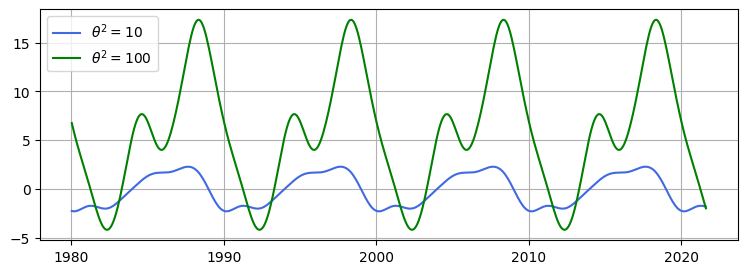

In [16]:
# theta_sq controls the amplitude of the superimposed function
#   it determines the amplitude of the osciallations and alters that of the underlying paths

plt.figure(figsize=(9, 3))
sample = gp_sample(ts, kernel_fn(theta_sq=10., tau=10.))
plt.plot(ts, sample, color='royalblue', label=r'$\theta^2 = 10$')
sample = gp_sample(ts, kernel_fn(theta_sq=100., tau=10.))
plt.plot(ts, sample, color='green', label=r'$\theta^2 = 100$')
plt.legend()
plt.grid()
plt.show()

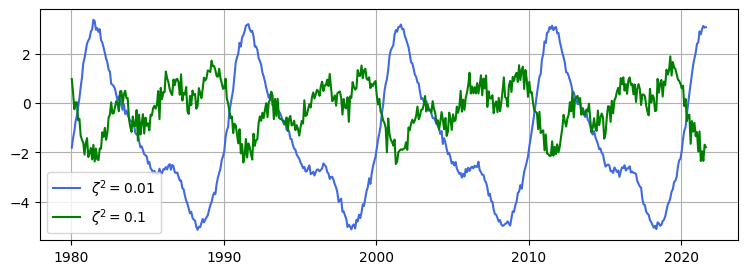

In [17]:
# zeta_sq introduces additional point variances
#   small zeta_sq (in comparison with theta_sq and phi_sq) will imply smaller point fluctuations leading to smoother functions 

plt.figure(figsize=(9, 3))
sample = gp_sample(ts, kernel_fn(theta_sq=10., tau=10., zeta_sq=0.01))
plt.plot(ts, sample, color='royalblue', label=r'$\zeta^2 = 0.01$')
sample = gp_sample(ts, kernel_fn(theta_sq=10., tau=10., zeta_sq=0.1))
plt.plot(ts, sample, color='green', label=r'$\zeta^2 = 0.1$')
plt.legend()
plt.grid()
plt.show()

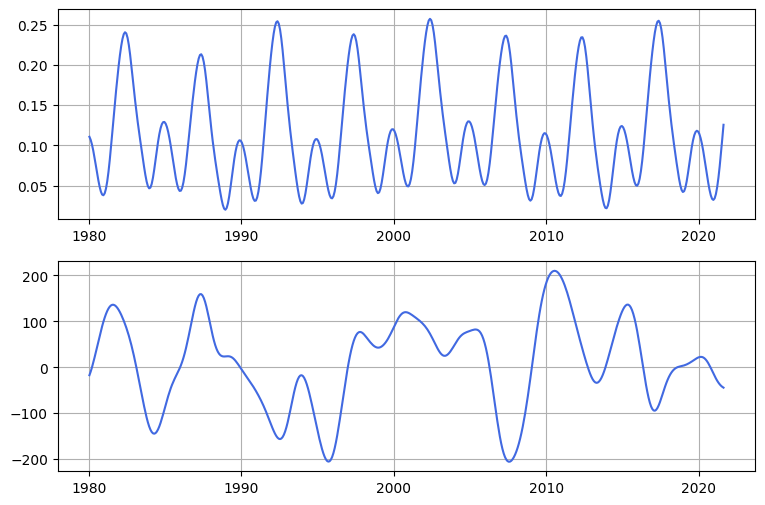

In [18]:
# phi_sq determines the significance of the oscillations
#   high phi_sq implies the amplitude of the oscillation is insignificant compared to that of the underlying path

fig, axs = plt.subplots(2, 1, figsize=(9, 6))

sample = gp_sample(ts, kernel_fn(theta_sq=0.01, tau=5., phi_sq=0.01))
axs[0].plot(ts, sample, color='royalblue')
axs[0].grid()

sample = gp_sample(ts, kernel_fn(theta_sq=100., tau=5., phi_sq=100.))
axs[1].plot(ts, sample, color='royalblue')
axs[1].grid()

plt.show()

In [19]:
ts_2yrs = ts[:24]

for theta_sq in (30., 35., 40., 45., 50.):
    kernel_mat = kernel_mat_from_kernel_fn(kernel_fn(theta_sq=theta_sq, sigma_sq=15., tau=1.), ts_2yrs)
    lst = []
    for _ in range(1_000):
        sample = np.random.multivariate_normal(mean=np.zeros(ts_2yrs.size), cov=kernel_mat)
        lst.append(np.ptp(sample))
    print(f'theta_sq = {theta_sq}, mean(range) = {np.mean(lst):.3f}, std(range) = {np.std(lst):.3f}')

theta_sq = 30.0, mean(range) = 3.499, std(range) = 1.762
theta_sq = 35.0, mean(range) = 3.857, std(range) = 1.905
theta_sq = 40.0, mean(range) = 3.982, std(range) = 1.979
theta_sq = 45.0, mean(range) = 4.241, std(range) = 2.112
theta_sq = 50.0, mean(range) = 4.505, std(range) = 2.187


In [ ]:
for phi_sq in (0.10, 0.15, 0.20, 0.25, 0.30):
    kernel_mat = kernel_mat_from_kernel_fn(kernel_fn(theta_sq=40., sigma_sq=15., tau=1., phi_sq=phi_sq, eta_sq=20.), ts)
    lst = []
    for _ in range(1_000):
        sample = np.random.multivariate_normal(mean=np.zeros(ts.size), cov=kernel_mat)
        lst.append(np.ptp(sample))
    print(f'phi_sq = {phi_sq}, mean(range) = {np.mean(lst):.3f}, std(range) = {np.std(lst):.3f}')

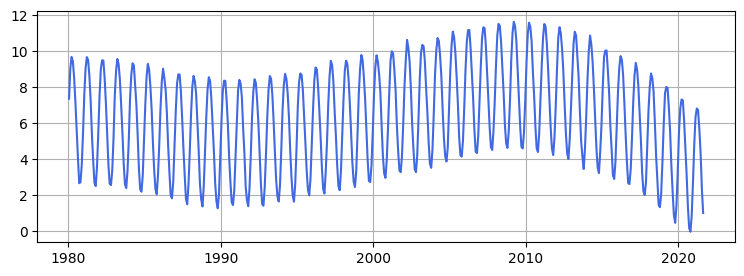

In [20]:
# experiments give us that we should set <theta_sq to 40> for the mean range of the oscillation to be ~4
# oscillations within cycles are smooth so we can set <sigma_sq to 15>
# we want <tau equal to 1> because only in that case we will see 42 cycles (one for each year)
#   this is because for the exponent in the first term to be 0, s-t must be an integer
#   and that repeats after 1 year because of how decimal year is defined
# experiments give us that we should set <phi_sq to 0.15> for the mean range of the sample to be ~11
# need high value of eta_sq to ensure the underlying function is smooth (quadratic like for g)
#   but not too high otherwise the high covariance will prevent the GP from capturing the increasing trend
# <low but non-zero zeta_sq> because we see no jumps but slightly peaky crests

sample = gp_sample(ts, kernel_fn(theta_sq=40., sigma_sq=15., tau=1., phi_sq=0.15, eta_sq=55., zeta_sq=0.01))
plt.figure(figsize=(9, 3))
plt.plot(ts, sample, color='royalblue')
plt.grid()
plt.show()

In [21]:
decimals = ts[:12]-int(ts[0])
test_ts = np.hstack([year+decimals for year in range(1980, 2036)])[500:]

In [22]:
chosen_kernel_fn = kernel_fn(theta_sq=40., sigma_sq=15., tau=1., phi_sq=0.15, eta_sq=55., zeta_sq=0.01)

train_train_kernel_mat = kernel_mat_from_kernel_fn(chosen_kernel_fn, ts); train_precision = np.linalg.inv(train_train_kernel_mat)
train_test_kernel_mat = kernel_mat_from_kernel_fn(chosen_kernel_fn, ts, test_ts)
test_test_kernel_mat = kernel_mat_from_kernel_fn(chosen_kernel_fn, test_ts)

train_train_kernel_mat.shape, train_test_kernel_mat.shape, test_test_kernel_mat.shape

((500, 500), (500, 172), (172, 172))

In [23]:
test_y_mean = train_test_kernel_mat.T @ train_precision @ g_obs
test_y_cov = test_test_kernel_mat - train_test_kernel_mat.T @ train_precision @ train_test_kernel_mat

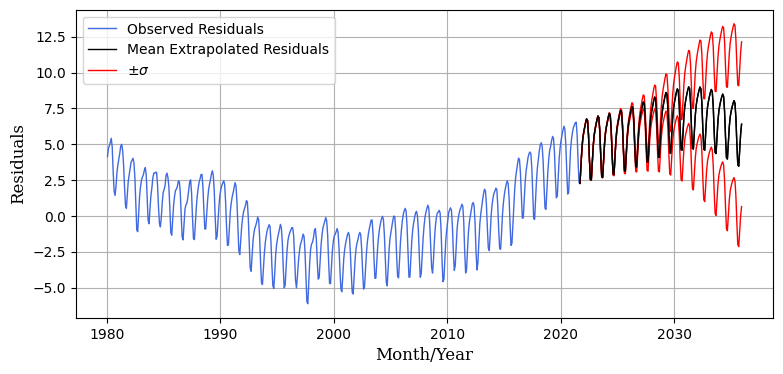

In [24]:
plt.figure(figsize=(9, 4))

plt.plot(ts, g_obs, color='royalblue', linewidth=1., label='Observed Residuals')
plt.plot(test_ts, test_y_mean, color='black', linewidth=1., label='Mean Extrapolated Residuals')
plt.plot(test_ts, test_y_mean+np.diag(test_y_cov), color='red', linewidth=1., label=r'$\pm \sigma$')
plt.plot(test_ts, test_y_mean-np.diag(test_y_cov), color='red', linewidth=1.,)
plt.plot(test_ts, test_y_mean, color='black', linewidth=1.)

plt.xlabel('Month/Year', font='serif', size=12)
plt.ylabel('Residuals', font='serif', size=12)
plt.legend()
plt.grid()
plt.show()

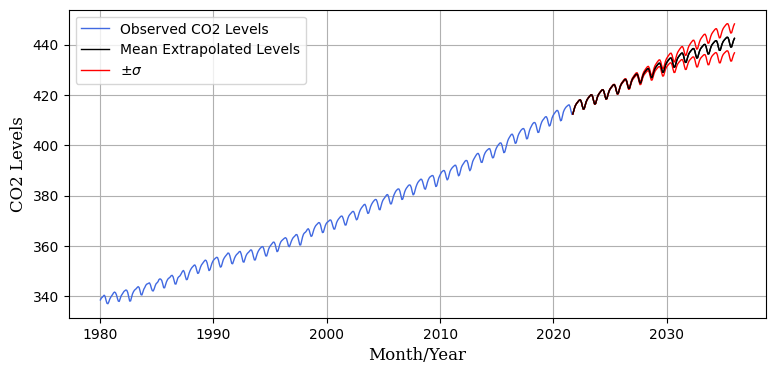

In [25]:
atb = posterior_mean[0]*test_ts + posterior_mean[1]

plt.figure(figsize=(9, 4))

plt.plot(ts, f_ts, color='royalblue', linewidth=1., label='Observed CO2 Levels')
plt.plot(test_ts, atb+test_y_mean, color='black', linewidth=1., label='Mean Extrapolated Levels')
plt.plot(test_ts, atb+test_y_mean+np.diag(test_y_cov), color='red', linewidth=1., label=r'$\pm \sigma$')
plt.plot(test_ts, atb+test_y_mean-np.diag(test_y_cov), color='red', linewidth=1.,)
plt.plot(test_ts, atb+test_y_mean, color='black', linewidth=1.)

plt.xlabel('Month/Year', font='serif', size=12)
plt.ylabel('CO2 Levels', font='serif', size=12)
plt.legend()
plt.grid()
plt.show()

In [26]:
# with increasing theta_sq and/or phi_sq, the error bars become wider (and vice-versa)
# predicted amplitude of oscillations does not vary much by changing theta_sq
# heavy dependence on tau because it controls the period of oscillations
# sensitive to eta_sq:
#   setting a low value leads to the predictions to fall back near the mean 0
#   setting a high value leads to predictions oscillating around a fixed baseline -- the last observed residual 
# not sensitive to the setting of sigma_sq, zeta_sq

chosen_kernel_fn = kernel_fn(theta_sq=40., sigma_sq=15., tau=1., phi_sq=0.15, eta_sq=55., zeta_sq=0.01)

train_train_kernel_mat = kernel_mat_from_kernel_fn(chosen_kernel_fn, ts); train_precision = np.linalg.inv(train_train_kernel_mat)
train_test_kernel_mat = kernel_mat_from_kernel_fn(chosen_kernel_fn, ts, test_ts)
test_test_kernel_mat = kernel_mat_from_kernel_fn(chosen_kernel_fn, test_ts)

test_y_mean = train_test_kernel_mat.T @ train_precision @ g_obs
test_y_cov = test_test_kernel_mat - train_test_kernel_mat.T @ train_precision @ train_test_kernel_mat

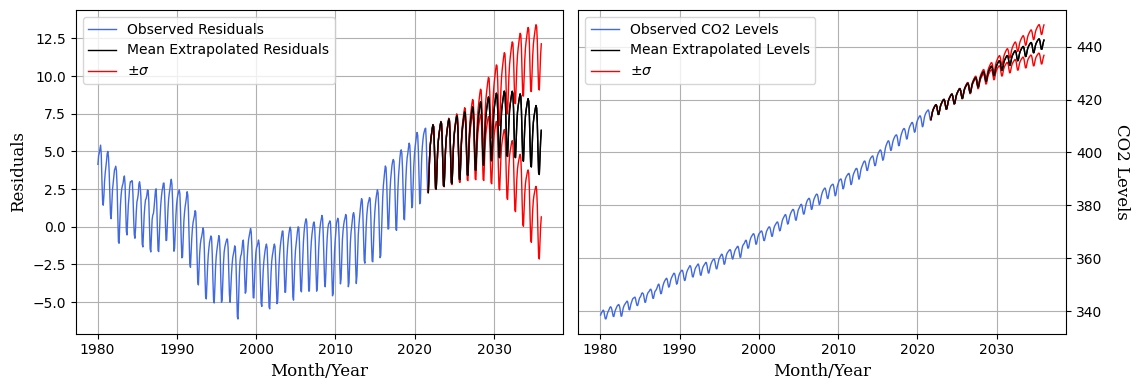

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(11.5, 4))

axs[0].plot(ts, g_obs, color='royalblue', linewidth=1., label='Observed Residuals')
axs[0].plot(test_ts, test_y_mean, color='black', linewidth=1., label='Mean Extrapolated Residuals')
axs[0].plot(test_ts, test_y_mean+np.diag(test_y_cov), color='red', linewidth=1., label=r'$\pm \sigma$')
axs[0].plot(test_ts, test_y_mean-np.diag(test_y_cov), color='red', linewidth=1.,)
axs[0].plot(test_ts, test_y_mean, color='black', linewidth=1.)

axs[0].set_xlabel('Month/Year', font='serif', size=12)
axs[0].set_ylabel('Residuals', font='serif', size=12)
axs[0].legend()
axs[0].grid()

axs[1].plot(ts, f_ts, color='royalblue', linewidth=1., label='Observed CO2 Levels')
axs[1].plot(test_ts, atb+test_y_mean, color='black', linewidth=1., label='Mean Extrapolated Levels')
axs[1].plot(test_ts, atb+test_y_mean+np.diag(test_y_cov), color='red', linewidth=1., label=r'$\pm \sigma$')
axs[1].plot(test_ts, atb+test_y_mean-np.diag(test_y_cov), color='red', linewidth=1.,)
axs[1].plot(test_ts, atb+test_y_mean, color='black', linewidth=1.)

axs[1].set_xlabel('Month/Year', font='serif', size=12)
axs[1].set_ylabel('CO2 Levels', font='serif', size=12, labelpad=20, rotation=270)
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
axs[1].legend()
axs[1].grid()

fig.tight_layout()
plt.show()

In [31]:
residuals = kernel_fn(theta_sq=40., sigma_sq=15., tau=1., phi_sq=0.15, eta_sq=55., zeta_sq=0.01)
linear = lambda s, t: np.dot(s, t)
gp_kernel = lambda s, t: 1.*linear(s, t) + 0.*residuals(s, t)

train_train_kernel_mat = kernel_mat_from_kernel_fn(gp_kernel, ts); train_precision = np.linalg.inv(train_train_kernel_mat+(1e-8)*np.eye(ts.size))
train_test_kernel_mat = kernel_mat_from_kernel_fn(gp_kernel, ts, test_ts)
test_test_kernel_mat = kernel_mat_from_kernel_fn(gp_kernel, test_ts)

test_y_mean = train_test_kernel_mat.T @ train_precision @ f_ts
test_y_cov = test_test_kernel_mat - train_test_kernel_mat.T @ train_precision @ train_test_kernel_mat

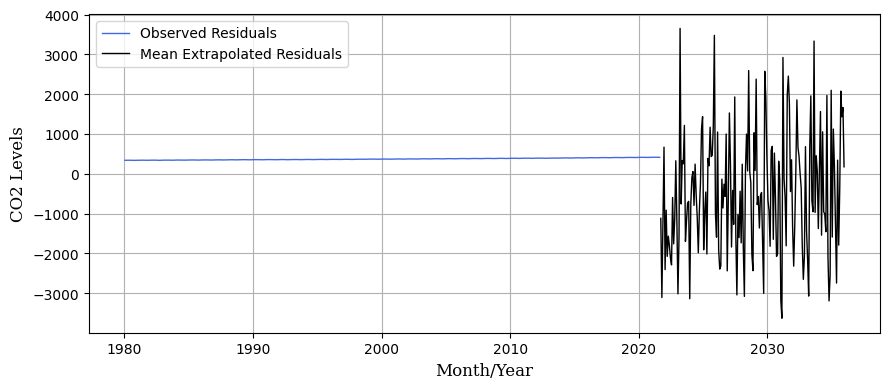

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(9, 4))

axs.plot(ts, f_ts, color='royalblue', linewidth=1., label='Observed Residuals')
axs.plot(test_ts, test_y_mean, color='black', linewidth=1., label='Mean Extrapolated Residuals')
# axs.plot(test_ts, test_y_mean+360+np.diag(test_y_cov), color='red', linewidth=1., label=r'$\pm \sigma$')
# axs.plot(test_ts, test_y_mean-np.diag(test_y_cov), color='red', linewidth=1.,)
# axs.plot(test_ts, test_y_mean, color='black', linewidth=1.)

axs.set_xlabel('Month/Year', font='serif', size=12)
axs.set_ylabel('CO2 Levels', font='serif', size=12)
axs.legend()
axs.grid()

fig.tight_layout()
plt.show()